In [1]:
from tools import adap_whitening_2, load, estimate_derivative
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.ticker import FuncFormatter

In [2]:
from matplotlib import font_manager as fm, rcParams

path = r"/home/p308270/.local/share/fonts/Helvetica.ttf"  # or .otf
fm.fontManager.addfont(path)
rcParams["font.family"] = fm.FontProperties(fname=path).get_name()


In [3]:
def off_events(sig, thresh):
    """
    Return a 0/1 array same length as `sig`.
    A 1 is placed where the signal crosses `thresh` from above to below.
    (Rising crossings stay 0.)
    """
    sig = np.asarray(sig)
    above = sig > thresh          # treat equality as "not above"
    cross = above[:-1] & ~above[1:]  # True where it goes True -> False
    out = np.zeros_like(sig, dtype=int)
    out[1:][cross] = 1            # mark at the first sample below the thresh
    return out

# --- Find contiguous runs of same label within the window ---
def find_runs(arr: np.ndarray):
    """Return list of (start_idx, end_idx, value) runs for 1D array arr (end exclusive)."""
    runs = []
    if arr.size == 0:
        return runs
    start = 0
    val = arr[0]
    for i in range(1, arr.size):
        if arr[i] != val:
            runs.append((start, i, val))
            start = i
            val = arr[i]
    runs.append((start, arr.size, val))
    return runs

In [4]:
file = '1_600_20'
i0, i1 = 290, 500
thresh = 800

data, sequence, times_sec, sequence_sec = load(file, reduced=True)
d_sensor_data = np.apply_along_axis(estimate_derivative, axis=0, arr=data)
data = np.hstack((data, d_sensor_data))
sig = np.sum(np.abs(d_sensor_data), axis=1)
teacher = off_events(sig, thresh=700)

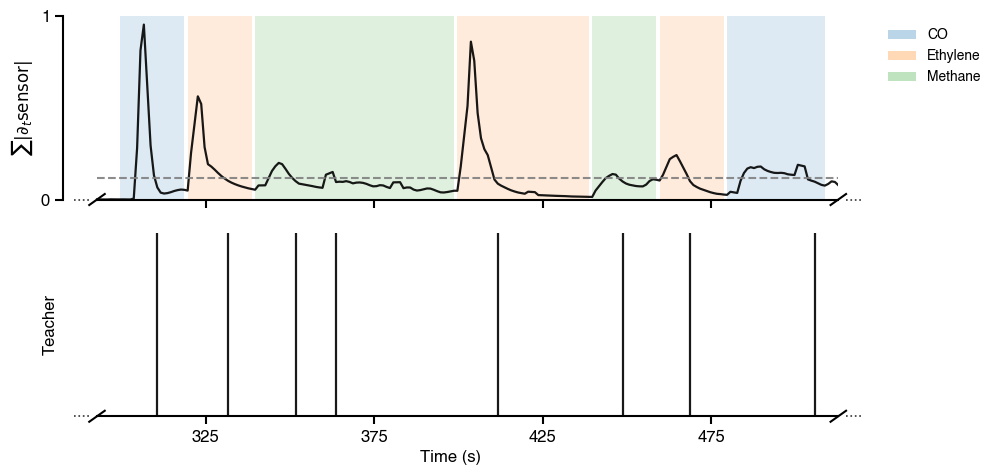

In [128]:
y = sig[i0:i1]
x = times_sec[i0:i1]   # time in seconds for the x-axis
teacher_win = teacher[i0:i1]
x_start = times_sec[0]

# --- Build per-sample gas label array across the whole recording ---
# Assumes sequence[i][1] holds an integer gas label (1..N). Adjust if needed.
colour = np.zeros_like(times_sec, dtype=int)
for i in range(len(sequence_sec)):
    t_start = sequence_sec[i]
    t_end = sequence_sec[i + 1] if i + 1 < len(sequence_sec) else np.inf
    mask = (times_sec >= t_start) & (times_sec < t_end)
    colour[mask] = int(sequence[i][1])

# Extract labels for our local window and compute runs
labels_local = colour[i0:i1]  # integer label per sample (0 = no gas/unknown)
runs = find_runs(labels_local)

# --- Figure with two subplots (top: signal, bottom: teacher) ---
cm = plt.get_cmap('tab10')
fig, (ax, ax2) = plt.subplots(2, 1, figsize=(10, 5.2),
                              sharex=True, gridspec_kw={'hspace': 0.18})

# Top: signal with gas-colored rectangles
ax.plot(x, y, lw=1.6, color='black', alpha=0.9)
# ax.axhline(y=thresh, linestyle='--', linewidth=1.5, color='0.5', alpha=0.9)

# Shade runs; use [s, e] in time (clamped to window) and your offsets (-3, -4)
for s, e, val in runs:
    if val == 0:
        continue
    x0 = x[s]
    x1 = x[e] if e < len(x) else x[-1]
    ax.axvspan(x0 - 3.0, x1 - 4.0, facecolor=cm((val - 1) % 10), alpha=0.15, linewidth=0)

# Cosmetics (top)
ax.set_xlim(x[0], x[-1])
ax.set_ylabel(r'$\sum |\partial_t \mathrm{sensor}|$', fontsize=12)
ax.spines[['top', 'right']].set_visible(False)
for spine in ['left', 'bottom']:
    ax.spines[spine].set_linewidth(1.5)
ax.tick_params(axis="both", width=1.5, length=6, labelsize=12)
y1 = ax.get_ylim()
ax.set_ylim(0, y1[1])
ax.set_yticks([0,y1[1]], labels=[0,1])

# Optional legend for gases present in this window
unique_labels = sorted(set(labels_local) - {0})
gases = ['CO', 'Ethylene', 'Methane']
if unique_labels:
    handles = [
        Patch(facecolor=cm((g - 1) % 10), alpha=0.3, edgecolor='none', label=f'{gases[g-1]}')
        for g in unique_labels
    ]
    ax.legend(handles=handles, frameon=False, loc='upper right', bbox_to_anchor=(1.2, 1))

# Bottom: Teacher as vertical lines at times where teacher==1
event_idx = np.flatnonzero(teacher_win == 1)
event_times = x[event_idx] if event_idx.size else np.array([])

# draw vertical lines from 0 to 1 for each event time
if event_times.size:
    ax2.vlines(event_times, 0, 1, colors='black', linewidth=1.6, alpha=0.9)

ax2.set_ylim(0., 1.)
ax2.set_yticks([])
ax2.set_ylabel('Teacher', fontsize=12)
ax2.set_xlabel('Time (s)', fontsize=12)
ax2.spines[['top', 'right']].set_visible(False)
for spine in ['left', 'bottom']:
    ax2.spines[spine].set_linewidth(1.5)
ax2.tick_params(axis="both", width=1.5, length=6, labelsize=12)
formatter = FuncFormatter(lambda t, pos: f"{t - x_start + 3:.0f}")
ax2.xaxis.set_major_formatter(formatter)
x_lim = ax2.get_xlim()
ax2.spines['bottom'].set_bounds(x_lim[0], x_lim[1])
ax2.set_xlim(x_lim[0]-10, x_lim[1])
ax.spines['bottom'].set_bounds(x_lim[0], x_lim[1])
ax.set_xlim(x_lim[0]-10, x_lim[1])
ax2.spines['left'].set_visible(False)

# --- Break slashes + dotted continuation at the visible spine bounds ---
# Uses data-x / axes-y transform so they stick to x_lim[0], x_lim[1]
dxf = 0.01   # half-length of slash as fraction of current x-range
dy  = 0.03   # half-height of slash in axes coords
stub = 3.0   # how many 'dx' units to draw the dotted stubs

for a in (ax, ax2):
    trans = a.get_xaxis_transform()  # x in data coords, y in axes coords
    x0_vis, x1_vis = x_lim[0], x_lim[1]
    xr = a.get_xlim()[1] - a.get_xlim()[0]
    dx = dxf * xr

    # rotated slashes (leaning up-right); tweak +/-dy for angle
    a.plot([x0_vis - dx, x0_vis + dx], [-dy, +dy],
           transform=trans, color='k', linewidth=1.5, clip_on=False)
    a.plot([x1_vis - dx, x1_vis + dx], [-dy, +dy],
           transform=trans, color='k', linewidth=1.5, clip_on=False)

    # dotted continuation BEFORE left slash (to the left)
    a.plot([x0_vis - stub*dx, x0_vis - dx], [0, 0],
           transform=trans, color='k', linewidth=1.2,
           linestyle=':', alpha=0.8, clip_on=False)

    # dotted continuation AFTER right slash (to the right)
    a.plot([x1_vis + dx, x1_vis + stub*dx], [0, 0],
           transform=trans, color='k', linewidth=1.2,
           linestyle=':', alpha=0.8, clip_on=False)

# --- Gray dashed threshold line starting at x_start ---
# draw after x-lims are final so xmax is correct
xmax_vis = ax.get_xlim()[1]
ax.hlines(thresh, xmin=x_lim[0], xmax=xmax_vis,
          linestyles='--', linewidth=1.5, color='0.5', alpha=0.9)
# plt.tight_layout()
# plt.savefig("figs/sketch_count_signal.png", dpi=600, bbox_inches="tight")
# plt.savefig("figs/sketch_count_signal.pdf", dpi=600, bbox_inches="tight")
plt.show()

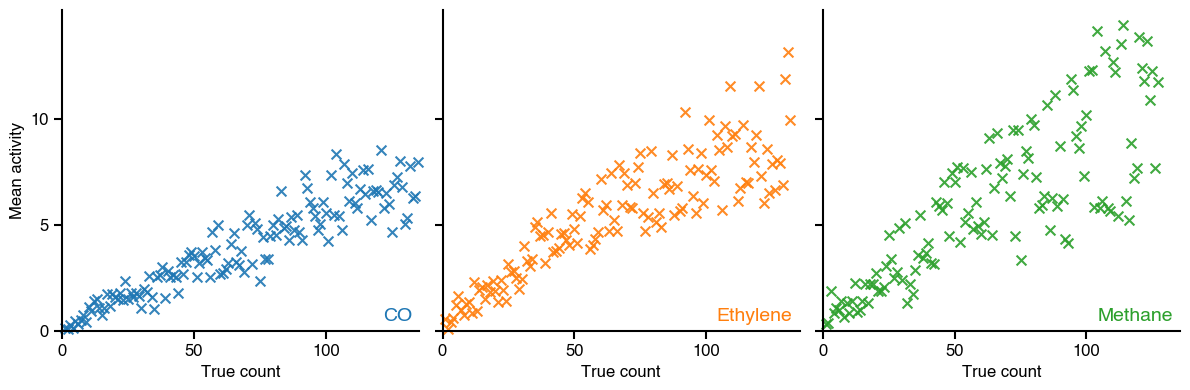

In [129]:
n_out = 1
n_hd = 10000
k = 25
p = 1./5.  # set your flip probability
rng = np.random.default_rng(42)  # optional: for reproducibility

x_dense = data

n_dense = x_dense.shape[1]
W_hd = np.random.binomial(n=1, p=0.05, size=(n_hd, n_dense))  # Test random sparse weights
x_hd = x_dense @ W_hd.T
z_hd = np.where(np.argsort(x_hd) < k, 1., 0)
W_out = np.zeros((n_out, n_hd))
output = np.zeros((x_dense.shape[0]))

for i, row in enumerate(z_hd):

    if teacher[i]:
        active_idx = np.flatnonzero(row)                          # indices where z_hd==1
        to_flip = active_idx[rng.random(active_idx.size) < p]     # Bernoulli(p) per active index
        W_out[0, to_flip] = 1.0

    out = row @ W_out.T
    output[i] = out

colour = np.zeros_like(times_sec, dtype=int)
for j in range(len(sequence_sec)):
    t0 = sequence_sec[j]
    t1 = sequence_sec[j+1] if j+1 < len(sequence_sec) else np.inf
    mask = (times_sec >= t0) & (times_sec < t1)
    colour[mask] = int(sequence[j][1])   # adjust if your gas id lives elsewhere

# helper (if not already defined)
def find_runs(arr: np.ndarray):
    """Return list of (start_idx, end_idx, value) runs for 1D array arr (end exclusive)."""
    runs = []
    if arr.size == 0:
        return runs
    start, val = 0, arr[0]
    for i in range(1, arr.size):
        if arr[i] != val:
            runs.append((start, i, val))
            start, val = i, arr[i]
    runs.append((start, arr.size, val))
    return runs

runs = find_runs(colour)

# Count how many presentations (blocks) each gas has in the whole recording
gas_presentations = {}

# Initialize dict-of-lists to collect per-block stats
block_sums = {
    "gas_id": [],
    "start_idx": [],
    "end_idx": [],          # end is exclusive
    "length": [],           # <-- NEW: block length (samples)
    "start_time": [],
    "end_time": [],
    "output_sum": [],
    "true_count": [],       # total presentations of that gas in the recording
}

# Fill the dict
for s, e, gas_id in runs:
    if gas_id == 0:
        continue
    gas_presentations[gas_id] = gas_presentations.get(gas_id, 0) + 1
    block_sums["gas_id"].append(int(gas_id))
    block_sums["start_idx"].append(int(s))
    block_sums["end_idx"].append(int(e))
    block_sums["length"].append(int(e - s))  # <-- NEW
    block_sums["start_time"].append(float(times_sec[s]))
    block_sums["end_time"].append(float(times_sec[e-1] if e-1 < len(times_sec) else times_sec[-1]))
    block_sums["output_sum"].append(float(output[s:e].sum()))
    block_sums["true_count"].append(int(gas_presentations[gas_id]))

# Extract arrays
gid = np.asarray(block_sums["gas_id"])
tc  = np.asarray(block_sums["true_count"])
os_ = np.asarray(block_sums["output_sum"], dtype=float)
L   = np.asarray(block_sums["length"], dtype=float)

# Mean output per block = sum / length
mean_os = os_ / np.maximum(L, 1.0)

labels = {1: 'CO', 2: 'Ethylene', 3: 'Methane'}
colors = plt.get_cmap('tab10')

# Shared limits so all panels have the same origin/crossing
xmax = max(1, np.nanmax(tc)) + 0.5
ymax = max(1e-9, np.nanmax(mean_os)) * 1.05  # based on mean, not sum

fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)

for ax, gas in zip(axes, [1, 2, 3]):
    m = (gid == gas)
    c = colors((gas - 1) % 10)
    if m.any():
        ax.scatter(
            tc[m], mean_os[m],
            marker='x', s=50, linewidths=1.5,
            color=c, alpha=0.9, clip_on=False
        )
    else:
        ax.text(0.5, 0.5, 'No data', transform=ax.transAxes,
                ha='center', va='center', alpha=0.6)

    # Colored gas label in bottom-right corner (replaces title)
    ax.text(
        0.98, 0.02, labels.get(gas, f'Gas {gas}'),
        transform=ax.transAxes, ha='right', va='bottom',
        color=c, fontsize=14
    )

    # Axes origin at (0, 0)
    ax.set_xlim(0, xmax)
    ax.set_ylim(0, ymax)
    ax.spines['left'].set_position(('data', 0))    # x=0 vertical spine
    ax.spines['bottom'].set_position(('data', 0))  # y=0 horizontal spine
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='both', width=1.5, length=6, labelsize=12)
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)
    ax.set_xticks([0, 50, 100])
    ax.set_yticks([0, 5, 10])

# shared labels
axes[0].set_ylabel('Mean activity', fontsize=12)
for ax in axes:
    ax.set_xlabel("True count", fontsize=12)

plt.tight_layout()
plt.savefig("figs/sketch_count_counts.png", dpi=600, bbox_inches="tight")
plt.savefig("figs/sketch_count_counts.pdf", dpi=600, bbox_inches="tight")
plt.show()


In [130]:
import matplotlib as mpl, shutil
shutil.rmtree(mpl.get_cachedir(), ignore_errors=True)


In [131]:
import matplotlib as mpl
from matplotlib import font_manager as fm

print("Matplotlib:", mpl.__version__)
print("Cache dir:", mpl.get_cachedir())

# What Helvetica-like fonts are visible?
hits = [f for f in fm.fontManager.ttflist
        if "helvet" in f.name.lower() or "helvet" in f.fname.lower()]
for f in hits:
    print(f.name, "->", f.fname)

# Will a lookup by family name succeed?
from matplotlib.font_manager import FontProperties, findfont
try:
    print("findfont('Helvetica'):", findfont(FontProperties(family="Helvetica"),
                                             fallback_to_default=False))
except Exception as e:
    print("findfont error:", e)

Matplotlib: 3.5.1
Cache dir: /home/p308270/.cache/matplotlib
Helvetica -> /home/p308270/.local/share/fonts/Helvetica.ttf
Helvetica -> /home/p308270/.local/share/fonts/Helvetica.ttf
findfont('Helvetica'): /home/p308270/.local/share/fonts/Helvetica.ttf


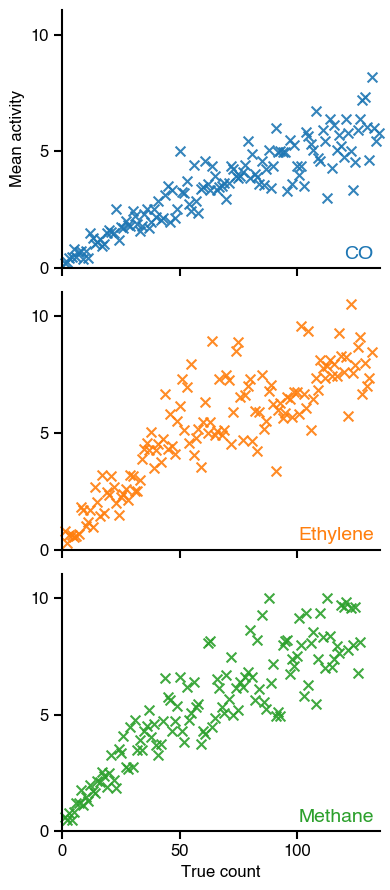

In [13]:
n_out = 1
n_hd = 10000
k = 25
p = 1./5.  # set your flip probability
rng = np.random.default_rng(42)  # optional: for reproducibility

x_dense = data

n_dense = x_dense.shape[1]
W_hd = np.random.binomial(n=1, p=0.05, size=(n_hd, n_dense))  # Test random sparse weights
x_hd = x_dense @ W_hd.T
z_hd = np.where(np.argsort(x_hd) < k, 1., 0)
W_out = np.zeros((n_out, n_hd))
output = np.zeros((x_dense.shape[0]))

for i, row in enumerate(z_hd):

    if teacher[i]:
        active_idx = np.flatnonzero(row)                          # indices where z_hd==1
        to_flip = active_idx[rng.random(active_idx.size) < p]     # Bernoulli(p) per active index
        W_out[0, to_flip] = 1.0

    out = row @ W_out.T
    output[i] = out

colour = np.zeros_like(times_sec, dtype=int)
for j in range(len(sequence_sec)):
    t0 = sequence_sec[j]
    t1 = sequence_sec[j+1] if j+1 < len(sequence_sec) else np.inf
    mask = (times_sec >= t0) & (times_sec < t1)
    colour[mask] = int(sequence[j][1])   # adjust if your gas id lives elsewhere

# helper (if not already defined)
def find_runs(arr: np.ndarray):
    """Return list of (start_idx, end_idx, value) runs for 1D array arr (end exclusive)."""
    runs = []
    if arr.size == 0:
        return runs
    start, val = 0, arr[0]
    for i in range(1, arr.size):
        if arr[i] != val:
            runs.append((start, i, val))
            start, val = i, arr[i]
    runs.append((start, arr.size, val))
    return runs

runs = find_runs(colour)

# Count how many presentations (blocks) each gas has in the whole recording
gas_presentations = {}

# Initialize dict-of-lists to collect per-block stats
block_sums = {
    "gas_id": [],
    "start_idx": [],
    "end_idx": [],          # end is exclusive
    "length": [],           # <-- NEW: block length (samples)
    "start_time": [],
    "end_time": [],
    "output_sum": [],
    "true_count": [],       # total presentations of that gas in the recording
}

# Fill the dict
for s, e, gas_id in runs:
    if gas_id == 0:
        continue
    gas_presentations[gas_id] = gas_presentations.get(gas_id, 0) + 1
    block_sums["gas_id"].append(int(gas_id))
    block_sums["start_idx"].append(int(s))
    block_sums["end_idx"].append(int(e))
    block_sums["length"].append(int(e - s))  # <-- NEW
    block_sums["start_time"].append(float(times_sec[s]))
    block_sums["end_time"].append(float(times_sec[e-1] if e-1 < len(times_sec) else times_sec[-1]))
    block_sums["output_sum"].append(float(output[s:e].sum()))
    block_sums["true_count"].append(int(gas_presentations[gas_id]))


# Extract arrays
gid = np.asarray(block_sums["gas_id"])
tc  = np.asarray(block_sums["true_count"])
os_ = np.asarray(block_sums["output_sum"], dtype=float)
L   = np.asarray(block_sums["length"], dtype=float)

# Mean output per block = sum / length
mean_os = os_ / np.maximum(L, 1.0)

labels = {1: 'CO', 2: 'Ethylene', 3: 'Methane'}
colors = plt.get_cmap('tab10')

# Shared limits so all panels have the same origin/crossing
xmax = max(1, np.nanmax(tc)) + 0.5
ymax = max(1e-9, np.nanmax(mean_os)) * 1.05  # based on mean, not sum

# --- vertical column of 3 subplots ---
fig, axes = plt.subplots(3, 1, figsize=(4, 9), sharex=True, sharey=True)

for ax, gas in zip(axes, [1, 2, 3]):
    m = (gid == gas)
    c = colors((gas - 1) % 10)
    if m.any():
        ax.scatter(
            tc[m], mean_os[m],
            marker='x', s=50, linewidths=1.5,
            color=c, alpha=0.9, clip_on=False
        )
    else:
        ax.text(0.5, 0.5, 'No data', transform=ax.transAxes,
                ha='center', va='center', alpha=0.6)

    # Colored gas label in bottom-right corner (replaces title)
    ax.text(
        0.98, 0.02, labels.get(gas, f'Gas {gas}'),
        transform=ax.transAxes, ha='right', va='bottom',
        color=c, fontsize=14
    )

    # Axes origin at (0, 0)
    ax.set_xlim(0, xmax)
    ax.set_ylim(0, ymax)
    ax.spines['left'].set_position(('data', 0))    # x=0 vertical spine
    ax.spines['bottom'].set_position(('data', 0))  # y=0 horizontal spine
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='both', width=1.5, length=6, labelsize=12)
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)
    ax.set_xticks([0, 50, 100])
    ax.set_yticks([0, 5, 10])

# shared labels
axes[0].set_ylabel('Mean activity', fontsize=12)
axes[2].set_xlabel("True count", fontsize=12)

plt.tight_layout()
# plt.savefig("figs/sketch_count_counts_vertical.png", dpi=200, bbox_inches="tight")
# plt.savefig("figs/sketch_count_counts_vertical.pdf", dpi=200, bbox_inches="tight")
plt.show()
